# Integrated Hydrology

This is a series of problems to test and demonstrate the integrated hydrology components of ATS.  Integrated hydrology consists of Richards equation in the subsurface coupled to a diffusion wave approximation on the surface system.  Coupling is done through assuming continuous pressure and flux across the surface-subsurface interface.

Tests demonstrate a 1D column (showing dry-to-wet and wet-to-dry transitions), a 2D "open book" problem (showing that water flows down hill) and a typical 2D "hillslope" problem comparable to the Sulis et al (WRR) benchmark problems.
### Input file name - column.xml
#### Richards flow and overland flow (with pressure bias)
#### Coupled water MPC - A coupler which intergrates surface and subsurface hydrology
#### Neumann outward mass flux at the bottom face - 0.04 mol m^{-2} s^{-1}
#### Initial hydrostatic head = 9 m
#### Constant input precipitation for overland flow - 3e-06 m for 12 hours (From where?)
#### Visualization - Every 864 seconds once - hence 200 results in total.  
#### Simulation time = 2 days
#### Compressible porosity also defined. 
Author: Ethan Coon

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data

import colors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar

import h5py
import pandas as pd
import xml.etree.ElementTree as ET

## Example 1: 1D infiltration

In the first example, we rain on a column for half a day, then turn off the rain.  A continuous, constant baseflow is applied as a sink at the bottom of the column.  Initially the column is partially saturated.  As rainfall > baseflow, the column saturates and ponded water expresses on the surface.  After rainfall stops, baseflow takes the water table below the surface again. 

This demonstrates the dry-to-wet and wet-to-dry transitions.

In [3]:
# load the ATS solution
directory = "./column.demo"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

vis_surf = ats_xdmf.VisFile(directory, domain='surface')
vis.loadMesh(columnar=True)


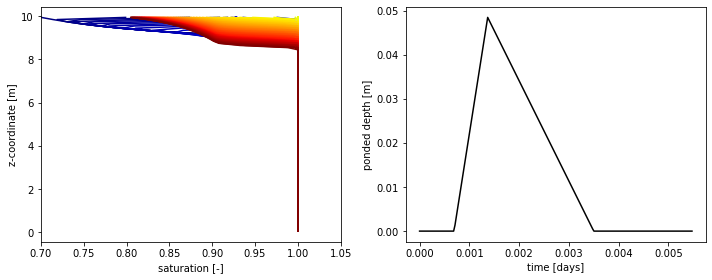

In [4]:
# plot the solution
fig, axs = plt.subplots(1,2, figsize=(10,4))

plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[0],
                                 'saturation [-]', cmap='jet')

axs[0].set_xlabel('saturation [-]')
axs[0].set_ylabel('z-coordinate [m]')
axs[0].set_xlim(0.7,1.05)

plot_column_data.plot_surface(vis_surf, ['ponded_depth',], axs[1], 'ponded depth [m]','k')
axs[1].set_xlabel("time [days]")
axs[1].set_ylabel("ponded depth [m]")

plt.tight_layout()
plt.show()

In [5]:
file_name = 'column.demo'
input_filename = 'column.xml'

In [6]:
# load the ATS solution
directory = f"./{file_name}/"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

 - Lighter color signifies earlier time steps. 

VGC parameters: alpha = 0.00015, m = 0.8, w_res = 0

### RK - work

In [7]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('base_porosity.cell.0')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'mass_density_liquid.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'precipitation_rain.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 group "/base_porosity.cell.0" (201 members)>


In [8]:
def inputfiles_pddataframes(file_name,t):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similary 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    """
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()

        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        z = np.arange(0.0,10.0,0.1)
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density



        molar_density_all = np.array(hdf.get(f'molar_density_liquid.cell.0/{t}'))
        molar_density = molar_density_all.flatten()
        data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density


        permeability_all = np.array(hdf.get(f'permeability.cell.0/{t}'))
        permeability = permeability_all.flatten()
        data_results['Absolute permeability [K] (m^{2})'] = permeability



        porosity_all = np.array(hdf.get(f'porosity.cell.0/{t}'))
        porosity = porosity_all.flatten()
        data_results['Porosity [phi] (-)'] = porosity

        pressure_all = np.array(hdf.get(f'pressure.cell.0/{t}'))
        pressure = pressure_all.flatten()
        data_results['Abs pressure [p_abs] [Pa]'] = pressure 
        # Water pressure or total pressure (Atm + water)? - Probably both

        relative_permeability_all = np.array(hdf.get(f'relative_permeability.cell.0/{t}'))
        relative_permeability = relative_permeability_all.flatten()
        data_results['Relative permeability [kr] [-]'] = relative_permeability


        saturation_gas_all = np.array(hdf.get(f'saturation_gas.cell.0/{t}'))
        saturation_gas = saturation_gas_all.flatten()
        data_results['Saturation of gas [s_g] [-]'] = saturation_gas


        saturation_liquid_all = np.array(hdf.get(f'saturation_liquid.cell.0/{t}'))
        saturation_liquid = saturation_liquid_all.flatten()
        data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid


        #temperature_all = np.array(hdf.get(f'temperature.cell.0/{t}'))
        #temperature = temperature_all.flatten()
        #data_results['Temperature [T] [K]'] = temperature


        viscosity_liquid_all = np.array(hdf.get(f'viscosity_liquid.cell.0/{t}'))
        viscosity_liquid = viscosity_liquid_all.flatten()
        data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid


        water_content_all = np.array(hdf.get(f'water_content.cell.0/{t}'))
        water_content = water_content_all.flatten()
        data_results['water_content [theta] mols'] = water_content
        
        return data_results

In [9]:
# Determining the time instances at which the data is stored

with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        print(time_period)
        # Time series stored in an irregular format! - 
        # ['0' '100' '103' '104' '105' '106' '107' '108' '109' '110' '111']

[  0  10 100 101 102 103 104 105 106 107 108 109  11 110 111 112 113 114
 115 116 117 118 119  12 120 121 122 123 124 125 126 127 128 129  13 130
 131 132 133 134 135 136 137 138 139  14 140 141 142 143 144 145 146 147
 148 149  15 150 151 152 153 154 155 156 157 158 159  16 160 161 162 163
 164 165 166 167 168 169  17 170 171 172 173 174 175 176 177 178 179  18
 180 181 182 183 184 185 186 187 188 189  19 190 191 192 193 194 195 196
 197 198 199  20 200 201 202 203 204 205 206 207  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79   8
  80  81  82  83  84  85  86  87  88  89   9  90  91  92  93  94  95  96
  97  98  99]


### Storing the data for all time instances

In [10]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i)

### Plotting the initial pressure:

In [11]:
data_results_0['Abs pressure [p_abs] [Pa]']

0.0    189090.764633
0.1    188110.141565
0.2    187129.518496
0.3    186148.895428
0.4    185168.272359
           ...      
9.5     95931.573123
9.6     94950.950055
9.7     93970.326986
9.8     92989.703917
9.9     92009.080849
Name: Abs pressure [p_abs] [Pa], Length: 100, dtype: float64

In [12]:
rho_avg = 1000 # kg m^{-3} - Provided by the developer 
g = 9.8006 # ms^{-2} - Provided by the user, g = (0,0,-9.8006m ms^{-2})
p_0 = 101325 # Pa

# Calculating the water pressure = p_abs -p_0
data_results_0['Water pressure [p_l] [Pa]'] = data_results_0['Abs pressure [p_abs] [Pa]'] - p_0

data_results_0['Pressure head [m]'] = data_results_0['Water pressure [p_l] [Pa]']/(rho_avg*g)

data_results_0['Elevation head [m]'] = data_results_0.index

data_results_0['Hydraulic head [m]'] = data_results_0['Pressure head [m]'] + data_results_0['Elevation head [m]']

data_results_0['Atmospheric pressure head [m]'] = 101325/(rho_avg*g)

data_results_0

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m]
0.0,0.1,1000.0,55508.373438,2.500000e-12,0.250087,189090.764633,3.273147,0.000000,1.000000,0.001696,1388.193734,87765.764633,8.955142,0.0,8.955142,10.338653
0.1,0.1,1000.0,55508.373438,2.500000e-12,0.250086,188110.141565,3.273147,0.000000,1.000000,0.001696,1388.188291,86785.141565,8.855085,0.1,8.955085,10.338653
0.2,0.1,1000.0,55508.373438,2.500000e-12,0.250085,187129.518496,3.273147,0.000000,1.000000,0.001696,1388.182847,85804.518496,8.755027,0.2,8.955027,10.338653
0.3,0.1,1000.0,55508.373438,2.500000e-12,0.250084,186148.895428,3.273147,0.000000,1.000000,0.001696,1388.177404,84823.895428,8.654970,0.3,8.954970,10.338653
0.4,0.1,1000.0,55508.373438,2.500000e-12,0.250083,185168.272359,3.273147,0.000000,1.000000,0.001696,1388.171961,83843.272359,8.554912,0.4,8.954912,10.338653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.5,0.1,1000.0,55508.373438,2.500000e-12,0.250000,95931.573123,0.005353,0.231564,0.768436,0.001696,1066.365654,-5393.426877,-0.550316,9.5,8.949684,10.338653
9.6,0.1,1000.0,55508.373438,2.500000e-12,0.250000,94950.950055,0.003662,0.252381,0.747619,0.001696,1037.477707,-6374.049945,-0.650373,9.6,8.949627,10.338653
9.7,0.1,1000.0,55508.373438,2.500000e-12,0.250000,93970.326986,0.002628,0.270290,0.729710,0.001696,1012.624703,-7354.673014,-0.750431,9.7,8.949569,10.338653
9.8,0.1,1000.0,55508.373438,2.500000e-12,0.250000,92989.703917,0.001957,0.285937,0.714063,0.001696,990.912101,-8335.296083,-0.850488,9.8,8.949512,10.338653


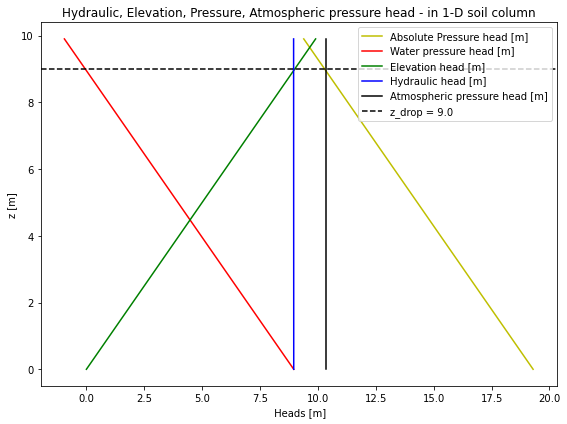

In [13]:
# To find the elevation where -ve pressure head begins
z_drop = data_results_0[data_results_0['Pressure head [m]'].le(0)].index[0]

z = np.arange(0,10,0.1)

fig = plt.figure(figsize=(8,6))

plt.title('Hydraulic, Elevation, Pressure, Atmospheric pressure head - in 1-D soil column')
plt.plot(data_results_0['Abs pressure [p_abs] [Pa]']/(rho_avg*g), z, 'y', label='Absolute Pressure head [m]')
plt.plot(data_results_0['Pressure head [m]'], z, 'r', label='Water pressure head [m]')
plt.plot(data_results_0['Elevation head [m]'], z, 'g', label='Elevation head [m]')
plt.plot(data_results_0['Hydraulic head [m]'], z, 'b', label='Hydraulic head [m]')
plt.plot(data_results_0['Atmospheric pressure head [m]'], z, 'k', label='Atmospheric pressure head [m]')
plt.axhline(y=z_drop,color='k',linestyle='--',label=f'z_drop = {z_drop}')
plt.ylabel('z [m]')
plt.xlabel(' Heads [m]')
plt.legend()
plt.tight_layout()
plt.show()

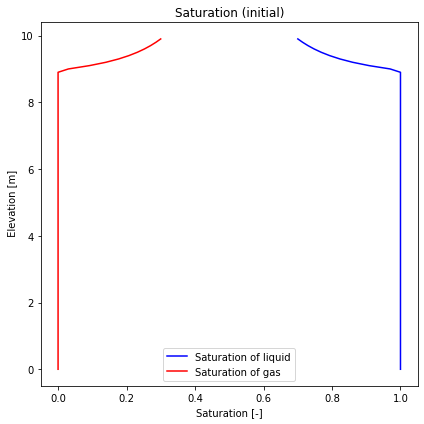

In [14]:
fig = plt.figure(figsize=(6,6))

plt.title('Saturation (initial)')
plt.plot(data_results_0['Saturation of liquid [s_l] [-]'], z, 'b', label='Saturation of liquid')
plt.plot(data_results_0['Saturation of gas [s_g] [-]'], z, 'r', label='Saturation of gas')

plt.xlabel('Saturation [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
plt.legend()
#plt.show()

* What is the sum of saturation of liquid and saturation of gas? Is'nt it 1? -It's okay

In [15]:
print(time_period.sort)

<built-in method sort of numpy.ndarray object at 0x7f22abe6c570>


In [16]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        print(time_period)

[  0   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207]


In [17]:
file_name

'column.demo'

In [18]:
time_period[1:]

array([  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 18

### Defining a dataframe that extracts the data for a single variable for all time instances

In [19]:
def input_datavar(file_name, variable):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        z = np.arange(0.0, 10, 0.1)
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    return data_var

In [20]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('saturation_liquid.cell.0/100')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'mass_density_liquid.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'precipitation_rain.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_liquid.cell.0', 'temperature.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 dataset "100": shape (100, 1), type "<f8">


In [21]:
### Accessing the variable at all time instances

file_name = 'column.demo'

variable = 'saturation_liquid'
saturation_data = input_datavar(file_name,variable)

saturation_data.columns = np.arange(0,201,1)

saturation_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
9.5,0.768436,0.768436,0.768437,0.768442,0.768481,0.768735,0.770173,0.779249,0.808640,0.876668,...,0.866414,0.865632,0.864860,0.864100,0.863350,0.862611,0.861882,0.861162,0.860452,0.859752
9.6,0.747619,0.747620,0.747645,0.747840,0.749008,0.755985,0.781144,0.842644,0.901814,0.916667,...,0.856678,0.855899,0.855131,0.854374,0.853628,0.852892,0.852166,0.851450,0.850744,0.850047
9.7,0.729710,0.729777,0.730782,0.737406,0.762330,0.820395,0.885185,0.911536,0.921135,0.924762,...,0.844918,0.844148,0.843389,0.842642,0.841905,0.841179,0.840462,0.839756,0.839059,0.838372
9.8,0.714063,0.718811,0.746536,0.808319,0.876233,0.908958,0.918707,0.923630,0.925922,0.926904,...,0.830210,0.829461,0.828724,0.827998,0.827283,0.826578,0.825883,0.825198,0.824523,0.823857
9.9,0.700220,0.798861,0.873562,0.908411,0.917822,0.923245,0.925503,0.926670,0.927246,0.927506,...,0.810860,0.810161,0.809473,0.808796,0.808129,0.807471,0.806824,0.806185,0.805556,0.804935


In [22]:
### Accessing the variable at all time instances

variable = 'pressure'
pressure_data = input_datavar(file_name,variable)

pressure_data.columns = np.arange(0,201,1)
pressure_data.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0.0,189090.764633,184344.160558,184114.013513,183931.947018,183731.234015,183496.937624,183263.622476,183110.742512,182941.061685,182748.817555,...,181788.779329,181592.174751,181404.569848,181278.472805,181140.680606,180987.967945,180814.670885,180610.971376,180445.672003,180318.139196
0.1,188110.141565,183412.375225,183182.229328,183000.163211,182799.450061,182565.153407,182331.838266,182178.958934,182009.277975,181817.033667,...,180856.995626,180660.390830,180472.785997,180346.689437,180208.897147,180056.184369,179882.887146,179679.187399,179513.888327,179386.355817
0.2,187129.518496,182480.586937,182250.443337,182068.377975,181867.664532,181633.367350,181400.052225,181247.174155,181077.492932,180885.248271,...,179925.210600,179728.605365,179541.000673,179414.905079,179277.112605,179124.399593,178951.102047,178747.401823,178582.103354,178454.571437
0.3,186148.895428,181548.795693,181318.655538,181136.591309,180935.877426,180701.579454,180468.264352,180315.388177,180145.706558,179953.461365,...,178993.424248,178796.818356,178609.213877,178483.119732,178345.326982,178192.613618,178019.315588,177815.614647,177650.317083,177522.786056
0.4,185168.272359,180617.001494,180386.865933,180204.803213,180004.088745,179769.789718,179536.474647,179383.600998,179213.918852,179021.672950,...,178061.636572,177865.029804,177677.425607,177551.333394,177413.540277,177260.826445,177087.527768,176883.825872,176718.529514,176590.999673


In [23]:
pressure_head_data = pressure_data/(10000)

In [24]:
pressure_head_data

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0.0,18.909076,18.434416,18.411401,18.393195,18.373123,18.349694,18.326362,18.311074,18.294106,18.274882,...,18.178878,18.159217,18.140457,18.127847,18.114068,18.098797,18.081467,18.061097,18.044567,18.031814
0.1,18.811014,18.341238,18.318223,18.300016,18.279945,18.256515,18.233184,18.217896,18.200928,18.181703,...,18.085700,18.066039,18.047279,18.034669,18.020890,18.005618,17.988289,17.967919,17.951389,17.938636
0.2,18.712952,18.248059,18.225044,18.206838,18.186766,18.163337,18.140005,18.124717,18.107749,18.088525,...,17.992521,17.972861,17.954100,17.941491,17.927711,17.912440,17.895110,17.874740,17.858210,17.845457
0.3,18.614890,18.154880,18.131866,18.113659,18.093588,18.070158,18.046826,18.031539,18.014571,17.995346,...,17.899342,17.879682,17.860921,17.848312,17.834533,17.819261,17.801932,17.781561,17.765032,17.752279
0.4,18.516827,18.061700,18.038687,18.020480,18.000409,17.976979,17.953647,17.938360,17.921392,17.902167,...,17.806164,17.786503,17.767743,17.755133,17.741354,17.726083,17.708753,17.688383,17.671853,17.659100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.5,9.593157,9.593157,9.593160,9.593186,9.593352,9.594458,9.600665,9.638341,9.744723,9.923827,...,9.901409,9.899642,9.897893,9.896160,9.894445,9.892745,9.891061,9.889393,9.887740,9.886102
9.6,9.495095,9.495100,9.495227,9.496222,9.502138,9.536392,9.645897,9.843839,9.973681,10.000230,...,9.878832,9.876967,9.875121,9.873292,9.871482,9.869688,9.867911,9.866151,9.864406,9.862677
9.7,9.397033,9.397432,9.403306,9.440886,9.565989,9.781541,9.941481,9.991273,10.007857,10.013939,...,9.849719,9.847737,9.845776,9.843833,9.841910,9.840005,9.838118,9.836249,9.834398,9.832563
9.8,9.298970,9.330066,9.489553,9.743677,9.922903,9.986690,10.003731,10.012052,10.015864,10.017487,...,9.810137,9.808021,9.805928,9.803855,9.801803,9.799772,9.797760,9.795768,9.793794,9.791839


In [25]:
### Accessing the variable at all time instances

variable = 'relative_permeability'
relative_permeability = input_datavar(file_name,variable)

relative_permeability.columns = np.arange(0,201,1)
relative_permeability.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0.0,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.1,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.2,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.3,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.4,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147


In [26]:
### Accessing the variable at all time instances

variable = 'relative_permeability'
relative_permeability = input_datavar(file_name,variable)

relative_permeability.columns = np.arange(0,201,1)
relative_permeability.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0.0,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.1,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.2,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.3,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147
0.4,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,...,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147,3.273147


Text(0.5, 0, 'Saturation (-)')

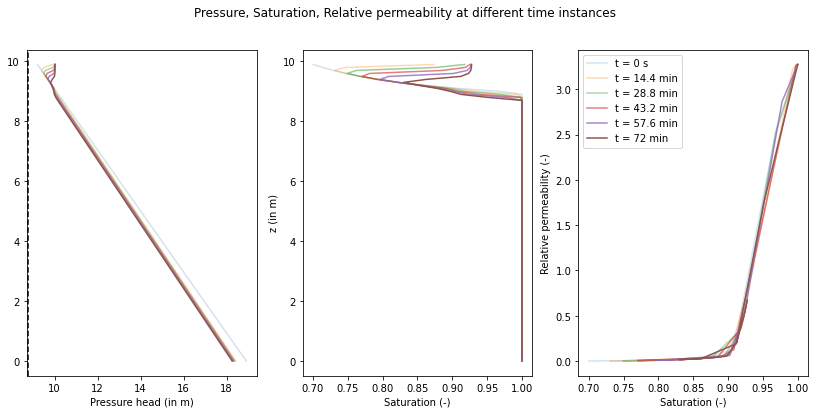

In [27]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = saturation_data.index

ax1.plot(saturation_data[0], z, alpha=0.2)
ax1.plot(saturation_data[2], z, alpha=0.3)
ax1.plot(saturation_data[4], z, alpha=0.5)
ax1.plot(saturation_data[6], z, alpha=0.6)
ax1.plot(saturation_data[8], z, alpha=0.8)
ax1.plot(saturation_data[10], z, alpha=1)
#ax1.plot(saturation_data[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation (-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2)
ax2.plot(pressure_head_data[2], z, alpha=0.3)
ax2.plot(pressure_head_data[4], z, alpha=0.4)
ax2.plot(pressure_head_data[6], z, alpha=0.6)
ax2.plot(pressure_head_data[8], z, alpha=0.8)
ax2.plot(pressure_head_data[10], z, alpha=1)
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.axvline(x=8.772805,color='k',linestyle='--',label='p-const = 8.77 m')
#ax2.legend()

ax3.plot(saturation_data[0], relative_permeability[0], alpha=0.2, label ='t = 0 s')
ax3.plot(saturation_data[2], relative_permeability[2], alpha=0.3, label ='t = 14.4 min')
ax3.plot(saturation_data[4], relative_permeability[4], alpha=0.4, label ='t = 28.8 min')
ax3.plot(saturation_data[6], relative_permeability[6], alpha=0.6, label ='t = 43.2 min')
ax3.plot(saturation_data[8], relative_permeability[8], alpha=0.8, label ='t = 57.6 min')
ax3.plot(saturation_data[10], relative_permeability[10], alpha=1, label ='t = 72 min')
#ax3.plot(saturation_data[200], relative_permeability[200], alpha=1, label ='t = 2 days')
ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


Text(0.5, 0, 'Pressure head (in m)')

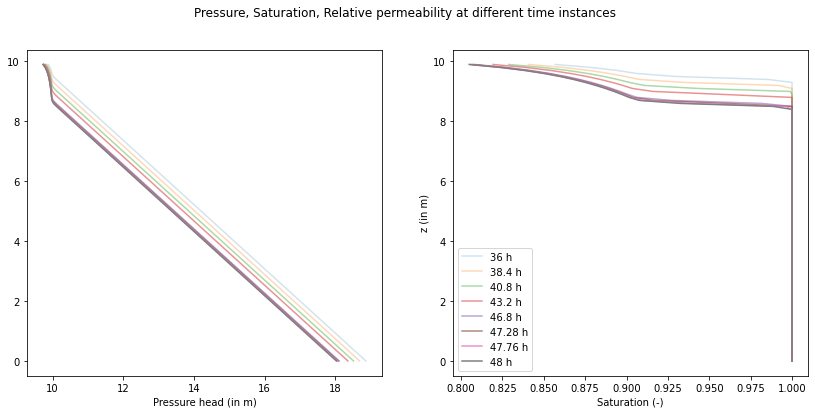

In [28]:
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = saturation_data.index

ax1.plot(saturation_data[150], z, alpha=0.2, label='36 h')
ax1.plot(saturation_data[160], z, alpha=0.3, label='38.4 h')
ax1.plot(saturation_data[170], z, alpha=0.4, label='40.8 h')
ax1.plot(saturation_data[180], z, alpha=0.5, label='43.2 h')
ax1.plot(saturation_data[195], z, alpha=0.6, label='46.8 h')
ax1.plot(saturation_data[197], z, alpha=0.7, label='47.28 h')
ax1.plot(saturation_data[199], z, alpha=0.8, label='47.76 h')
ax1.plot(saturation_data[200], z, alpha=1, label='48 h')
#ax1.plot(saturation_data[200], z, alpha=1)
ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation (-)')

ax2.plot(pressure_head_data[150], z, alpha=0.2, label='36 h')
ax2.plot(pressure_head_data[160], z, alpha=0.3, label='38.4 h')
ax2.plot(pressure_head_data[170], z, alpha=0.4, label='40.8 h')
ax2.plot(pressure_head_data[180], z, alpha=0.5, label='43.2 h')
ax2.plot(pressure_head_data[195], z, alpha=0.6, label='46.8 h')
ax2.plot(pressure_head_data[197], z, alpha=0.7, label='47.28 h')
ax2.plot(pressure_head_data[199], z, alpha=0.8, label='47.76 h')
ax2.plot(pressure_head_data[200], z, alpha=1, label='48 h')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
#ax2.axvline(x=8.772805,color='k',linestyle='--',label='p-const = 8.77 m')
#ax2.legend()


### Surface flow outputs

In [29]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    ponded_depth = hdf.get('surface-ponded_depth.cell.0/100')
    print(ponded_depth)

List of datasets in this file: 
 
 ['surface-aspect.cell.0', 'surface-cell_volume.cell.0', 'surface-elevation.cell.0', 'surface-manning_coefficient.cell.0', 'surface-mass_density_liquid.cell.0', 'surface-molar_density_liquid.cell.0', 'surface-overland_conductivity.cell.0', 'surface-ponded_depth.cell.0', 'surface-ponded_depth_bar.cell.0', 'surface-pres_elev.cell.0', 'surface-pressure.cell.0', 'surface-relative_permeability.cell.0', 'surface-slope_magnitude.cell.0', 'surface-source_molar_density.cell.0', 'surface-surface_subsurface_flux.cell.0', 'surface-temperature.cell.0', 'surface-velocity.cell.0', 'surface-velocity.cell.1', 'surface-velocity.cell.2', 'surface-water_content.cell.0', 'surface-water_content_bar.cell.0']


<HDF5 dataset "100": shape (1, 1), type "<f8">


In [30]:
def input_datavarsurface(file_name, variable):
    """
        Define once more!
    """
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            
    data_var = data_var.transpose()
            #data_var = pd.DataFrame(index=time_period[i],data=var)
    
    return data_var

In [158]:
file_name = 'column.demo'
variable = 'surface-surface_subsurface_flux'
surface_ponded_depth = input_datavarsurface(file_name,variable)

#surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

,0
0,NaN
8,-0.166167
9,-0.166167
10,-0.166167
11,-0.166167
...,...
203,0.0
204,0.0
205,0.0
206,0.0


<AxesSubplot:>

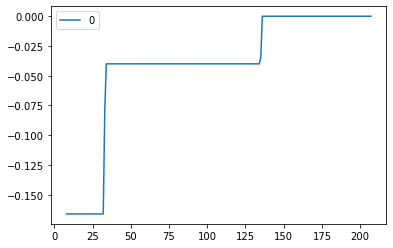

In [159]:
surface_ponded_depth.plot()

In [104]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        print(var_0)

[274.65]


In [137]:
data_var = pd.DataFrame(columns=time_period)
data_var[0] = var_all
data_var

,0,8,9,10,11,12,13,14,15,16,...,198,199,200,201,202,203,204,205,206,207
0,274.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
type(var_all)

numpy.ndarray

In [138]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            #data_var = pd.DataFrame(index=time_period[i],data=var)
print(data_var)     

   0       8       9       10      11      12      13      14      15   \
0  NaN  274.65  274.65  274.65  274.65  274.65  274.65  274.65  274.65   

      16   ...     198     199     200     201     202     203     204  \
0  274.65  ...  274.65  274.65  274.65  274.65  274.65  274.65  274.65   

      205     206     207  
0  274.65  274.65  274.65  

[1 rows x 201 columns]


In [141]:
type(data_var[0])

pandas.core.series.Series

In [95]:
variable = 'surface-water_content'
surface_ponded_depth = input_datavarsurface(file_name,variable)

surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

ValueError: Shape of passed values is (1, 1), indices imply (100, 1)

In [93]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        z = np.arange(0.0, 10, 0.1)
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/100'))
        var_0 = var_all_0.flatten()
        print(var_0)

[None]
